# Customer Churn Prediction — Feature Engineering & Final Modeling

## 📦 Overview

In this notebook, I focus on improving churn prediction performance by adding domain-driven feature engineering and re-evaluating machine learning models.

The goals here are to:
- Engineer meaningful new features based on business logic
- Retrain top models from the first notebook on the enhanced dataset
- Compare performance before and after feature engineering
- Validate final results using PyCaret's automated modeling

This builds on the foundation of the first notebook, aiming to push model performance further and strengthen the overall project.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

## 🔍 Data Overview and Initial Checks

I loaded the raw dataset again and confirmed:
- No missing values
- No duplicate rows
- All key features are present

This fresh load ensures a clean starting point for building engineered features.

In [ ]:
df = pd.read_csv(r"D:\Projects\Churn Prediction\Churn_Modelling.csv")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [7]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [8]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## 🌟 Feature Engineering

To boost predictive power, I created several new features:
- **BalanceZero**: Flag for customers with zero account balance
- **AgeGroup**: Binned age ranges
- **BalanceToSalaryRatio**: Ratio of account balance to salary
- **ProductUsage**: Interaction between number of products and activity status
- **TenureGroup**: Grouped tenure buckets
- **IsSenior**: Senior citizen flag
- **IsLoyalCustomer**: Loyalty flag based on tenure
- **SalaryGroup & CreditGroup**: Grouped percentile categories
- **EngagementScore**: Composite activity + tenure score
- **TotalValue**: Combined balance and salary
- **BalanceGroup**: Liquidity-based segmentation

These features aim to capture behavioral and financial patterns that raw columns miss.


In [9]:
# Binary feature for Balance
df["BalanceZero"] = (df['Balance'] == 0).astype(int)

# Age Group Bins
df['AgeGroup'] = pd.cut(df['Age'], bins=[18, 30, 40, 50, 60, 70, 80, 100], labels=['18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+'])

# Balance to Salary ratio
df['BalanceToSalaryRatio'] = df['Balance'] / df['EstimatedSalary']

# Interaction feature between NumOfProducts and IsActiveMember
df['ProductUsage'] = df['NumOfProducts'] * df['IsActiveMember']

# Tenure Grouping
df['TenureGroup'] = pd.cut(df['Tenure'], bins=[0, 2, 5, 7, 10], labels=['0-2', '3-5', '6-7', '8-10'])

# Senior Citizen Flag
df["IsSenior"] = (df["Age"] > 60).astype(int)

#Customer Loyalty Indicator (based on Tenure)
df["IsLoyalCustomer"] = (df["Tenure"] >= 7).astype(int)

# Estimated Salary Percentile Group
df['SalaryGroup'] = pd.qcut(df['EstimatedSalary'], q=4, labels=['Low', 'Medium', 'High', 'Very High'], duplicates='drop')

# Credit Score Grouping
df["CreditGroup"] = pd.cut(df["CreditScore"], bins=[300, 500, 650, 750, 850], labels=["Very Low", "Low", "Medium", "High"])

# Customer Engagement Score
df['EngagementScore'] = df['IsActiveMember'] * (df['Tenure'] + 1)

# Total Value of Account
df['TotalValue'] = df['Balance'] + df['EstimatedSalary']

# Segment customers based on liquidity
df['BalanceGroup'] = pd.qcut(df['Balance'], q=4, labels=['Low', 'Medium', 'High'], duplicates='drop')

## 🧩 Encoding and Cleanup

I applied:
- Label Encoding to `Gender`
- One-Hot Encoding to new grouped features (`SalaryGroup`, `AgeGroup`, `CreditGroup`, `TenureGroup`, `BalanceGroup`)
- Interaction terms between gender and geography (`male_germany`, `male_spain`)

I also dropped irrelevant identifiers (`RowNumber`, `CustomerId`, `Surname`) to clean the feature space.

In [10]:
le = LabelEncoder()
df["Gender"] = le.fit_transform(df["Gender"])
df = pd.get_dummies(df, columns=["Geography"], drop_first=True)
df['male_germany'] = df["Gender"] * df["Geography_Germany"]
df['male_spain'] = df["Gender"] * df["Geography_Spain"]

In [11]:
# List of new categorical columns to encode
cat_features = ['SalaryGroup', 'AgeGroup', 'CreditGroup', 'TenureGroup', 'BalanceGroup']

# Perform one-hot encoding
df = pd.get_dummies(df, columns=cat_features, drop_first=True)

In [12]:
print(df.columns[df.columns.str.contains('SalaryGroup|AgeGroup|CreditGroup|TenureGroup|BalanceGroup')])

Index(['SalaryGroup_Medium', 'SalaryGroup_High', 'SalaryGroup_Very High',
       'AgeGroup_30-39', 'AgeGroup_40-49', 'AgeGroup_50-59', 'AgeGroup_60-69',
       'AgeGroup_70-79', 'AgeGroup_80+', 'CreditGroup_Low',
       'CreditGroup_Medium', 'CreditGroup_High', 'TenureGroup_3-5',
       'TenureGroup_6-7', 'TenureGroup_8-10', 'BalanceGroup_Medium',
       'BalanceGroup_High'],
      dtype='object')


In [13]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

In [14]:
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,...,AgeGroup_70-79,AgeGroup_80+,CreditGroup_Low,CreditGroup_Medium,CreditGroup_High,TenureGroup_3-5,TenureGroup_6-7,TenureGroup_8-10,BalanceGroup_Medium,BalanceGroup_High
0,619,0,42,2,0.00,1,1,1,101348.88,1,...,False,False,True,False,False,False,False,False,False,False
1,608,0,41,1,83807.86,1,0,1,112542.58,0,...,False,False,True,False,False,False,False,False,False,False
2,502,0,42,8,159660.80,3,1,0,113931.57,1,...,False,False,True,False,False,False,False,True,False,True
3,699,0,39,1,0.00,2,0,0,93826.63,0,...,False,False,False,True,False,False,False,False,False,False
4,850,0,43,2,125510.82,1,1,1,79084.10,0,...,False,False,False,False,True,False,False,False,True,False


In [15]:
X = df.drop(['Exited'], axis=1)
y = df['Exited']

## ✂️ Train-Test Split and Scaling

I split the enhanced dataset:
- 80% for training
- 20% for testing

I applied standard scaling to all features, preparing them for model training.


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 🌲Random Forest with Feature-Engineered Data

I retrained a Random Forest model on the enhanced dataset using:
- 100 trees
- Max depth of 10
- Balanced class weights

Performance is evaluated using 5-fold cross-validation and F1-score.

In [18]:
rf_fe_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42
)

In [19]:
cv_scores = cross_val_score(rf_fe_model, X_train, y_train, cv=5, scoring ='f1', n_jobs=-1)
print("Cross-validated F1 score: ", cv_scores)
print("Mean F1 score: ", np.mean(cv_scores))

Cross-validated F1 score:  [0.59370315 0.60278207 0.66766917 0.61072902 0.58970359]
Mean F1 score:  0.612917400796557


In [20]:
rf_fe_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=5, random_state=42)

In [21]:
y_pred = rf_fe_model.predict(X_test)

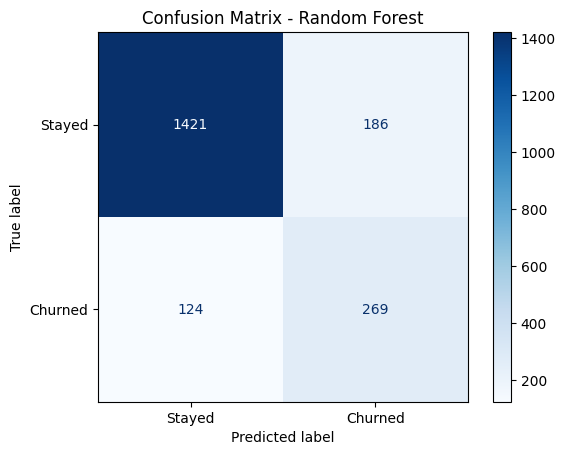

In [22]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Stayed', 'Churned'])

disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.show()

In [23]:
print(classification_report(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90      1607
           1       0.59      0.68      0.63       393

    accuracy                           0.84      2000
   macro avg       0.76      0.78      0.77      2000
weighted avg       0.86      0.84      0.85      2000

Accuracy:  0.845


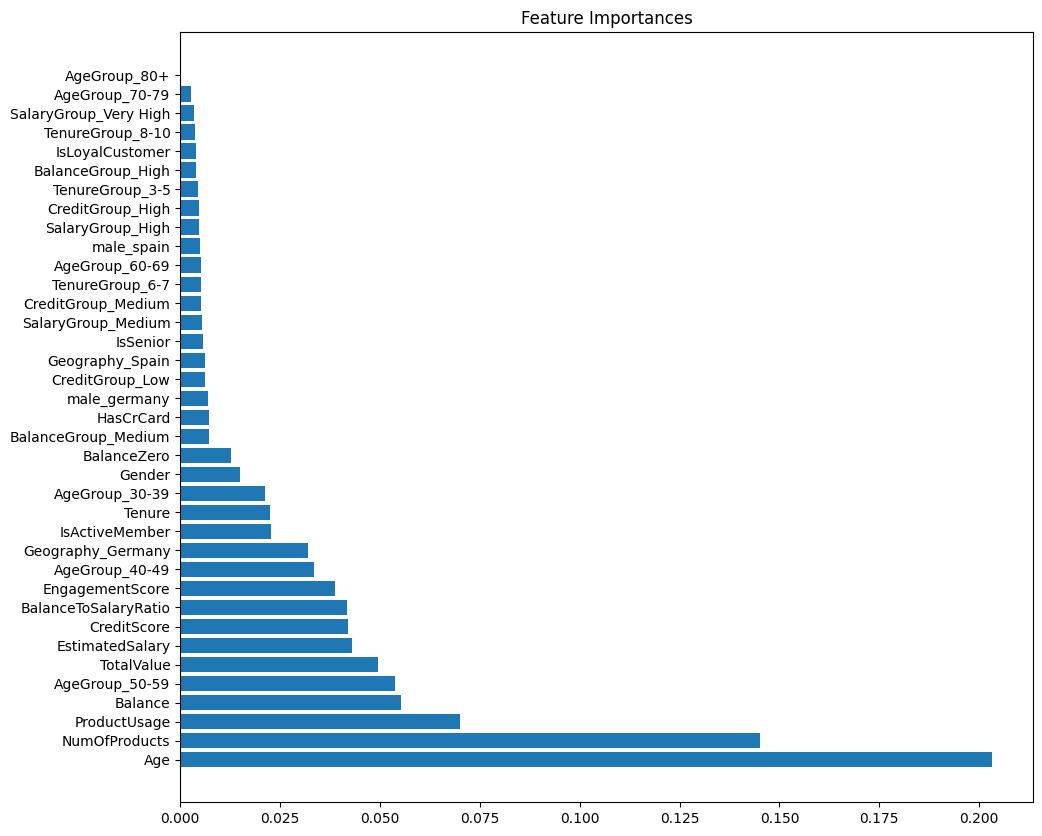

In [24]:
features = X.columns
importances = rf_fe_model.feature_importances_
indices = np.argsort(importances)[::-1]
names = [features[i] for i in indices]

plt.figure(figsize=(11,10))
plt.title('Feature Importances')
plt.barh(range(X.shape[1]), importances[indices])
plt.yticks(range(X.shape[1]), names)
plt.show()

### 📈 Evaluation: Random Forest

I visualized the confusion matrix and reviewed precision, recall, F1-score, and accuracy.

Feature importance plots highlight which engineered variables contribute most to churn prediction.

## 🏛 Logistic Regression on Enhanced Dataset

I retrained a Logistic Regression model with balanced class weights and evaluated its performance.

This serves as a strong linear baseline for comparison.

In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
log_reg_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

In [27]:
cv_scores = cross_val_score(log_reg_model, X_train, y_train, cv=5, scoring ='f1', n_jobs=-1)
print("Cross-validated F1 score: ", cv_scores)
print("Mean F1 score: ", np.mean(cv_scores))

Cross-validated F1 score:  [0.49278579 0.52934407 0.54345435 0.50270856 0.51351351]
Mean F1 score:  0.5163612570410447


In [28]:
log_reg_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [29]:
y_pred_log_reg_model = log_reg_model.predict(X_test)

In [30]:
conf_matrix_log_reg_model = confusion_matrix(y_test, y_pred_log_reg_model)
class_report_log_reg_model = classification_report(y_test, y_pred_log_reg_model)
accuracy_log_reg_model = accuracy_score(y_test, y_pred_log_reg_model)

In [31]:
print(conf_matrix_log_reg_model)
print(class_report_log_reg_model)
print(accuracy_log_reg_model)

[[1175  432]
 [ 111  282]]
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1607
           1       0.39      0.72      0.51       393

    accuracy                           0.73      2000
   macro avg       0.65      0.72      0.66      2000
weighted avg       0.81      0.73      0.75      2000

0.7285


## ⚡ Support Vector Machine (RBF Kernel)

I trained an RBF SVM on the enhanced dataset with balanced class weights.

As a non-linear classifier, SVM helps capture complex boundaries between churned and retained customers.

In [32]:
from sklearn.svm import SVC

In [33]:
svm_model = SVC(
    kernel='rbf',
    class_weight='balanced',
    random_state=42
)

In [34]:
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=5, scoring ='f1', n_jobs=-1)
print("Cross-validated F1 score: ", cv_scores)
print("Mean F1 score: ", np.mean(cv_scores))

Cross-validated F1 score:  [0.56041131 0.58344284 0.60947503 0.58977408 0.57036115]
Mean F1 score:  0.5826928811232814


In [35]:
svm_model.fit(X_train, y_train)

SVC(class_weight='balanced', random_state=42)

In [36]:
y_pred_svm_model = svm_model.predict(X_test)

In [37]:
coef_matrix_svm_model = confusion_matrix(y_test, y_pred_svm_model)
class_report_svm_model = classification_report(y_test, y_pred_svm_model)
accuracy_svm_model = accuracy_score(y_test, y_pred_svm_model)

In [38]:
print(coef_matrix_svm_model)
print(class_report_svm_model)
print(accuracy_svm_model)

[[1302  305]
 [ 101  292]]
              precision    recall  f1-score   support

           0       0.93      0.81      0.87      1607
           1       0.49      0.74      0.59       393

    accuracy                           0.80      2000
   macro avg       0.71      0.78      0.73      2000
weighted avg       0.84      0.80      0.81      2000

0.797


## 👥 K-Nearest Neighbors

I included KNN as a distance-based model, recognizing that its performance heavily depends on feature scaling.

I evaluated its performance using the same cross-validation strategy.

In [39]:
from sklearn.neighbors import KNeighborsClassifier

In [40]:
knn_model = KNeighborsClassifier(
    n_neighbors=5,
    weights='uniform',
    algorithm='auto'
)

In [41]:
cv_scores = cross_val_score(knn_model, X_train, y_train, cv=5, scoring ='f1', n_jobs=-1)
print("Cross-validated F1 score: ", cv_scores)
print("Mean F1 score: ", np.mean(cv_scores))

Cross-validated F1 score:  [0.40078585 0.35368421 0.40733198 0.44150943 0.38762887]
Mean F1 score:  0.3981880681289877


In [42]:
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [43]:
y_pred_knn_model = knn_model.predict(X_test)

In [44]:
coef_matrix_knn_model = confusion_matrix(y_test, y_pred_knn_model)
class_report_knn_model = classification_report(y_test, y_pred_knn_model)
accuracy_knn_model = accuracy_score(y_test, y_pred_knn_model)

In [45]:
print(coef_matrix_knn_model)
print(class_report_knn_model)
print(accuracy_knn_model)

[[1527   80]
 [ 264  129]]
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1607
           1       0.62      0.33      0.43       393

    accuracy                           0.83      2000
   macro avg       0.73      0.64      0.66      2000
weighted avg       0.81      0.83      0.81      2000

0.828


## 🔥 Gradient Boosting (GBM)

I trained a Gradient Boosting model on the enhanced dataset, leveraging its strength in handling non-linear relationships and boosting weak learners.

In [46]:
from sklearn.ensemble import GradientBoostingClassifier

In [47]:
gbm_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

In [48]:
cv_scores = cross_val_score(gbm_model, X_train, y_train, cv=5, scoring ='f1', n_jobs=-1)
print("Cross-validated F1 score: ", cv_scores)
print("Mean F1 score: ", np.mean(cv_scores))

Cross-validated F1 score:  [0.60721063 0.52859961 0.60966543 0.60283688 0.55078125]
Mean F1 score:  0.5798187577301117


In [49]:
gbm_model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [50]:
y_pred_gbm_model = gbm_model.predict(X_test)

In [51]:
coef_matrix_gbmm_model = confusion_matrix(y_test, y_pred_gbm_model)
class_report_gbm_model = classification_report(y_test, y_pred_gbm_model)
accuracy_gbm_model = accuracy_score(y_test, y_pred_gbm_model)

In [52]:
print(coef_matrix_gbmm_model)
print(class_report_gbm_model)
print(accuracy_gbm_model)

[[1541   66]
 [ 204  189]]
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.74      0.48      0.58       393

    accuracy                           0.86      2000
   macro avg       0.81      0.72      0.75      2000
weighted avg       0.86      0.86      0.85      2000

0.865


## ⚡ LightGBM

I trained a LightGBM model, known for its speed and accuracy on large, structured datasets.

Balanced class weights were included to address churn imbalance.

In [53]:
from lightgbm import LGBMClassifier

In [54]:
lgbm_model = LGBMClassifier(
    class_weight='balanced',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

In [55]:
cv_scores = cross_val_score(lgbm_model, X_train, y_train, cv=5, scoring ='f1', n_jobs=-1)
print("Cross-validated F1 score: ", cv_scores)
print("Mean F1 score: ", np.mean(cv_scores))

Cross-validated F1 score:  [0.59371069 0.60606061 0.6372549  0.59657143 0.58942065]
Mean F1 score:  0.6046036566657115


In [56]:
lgbm_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 1644, number of negative: 6356
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1455
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

LGBMClassifier(class_weight='balanced', max_depth=3, random_state=42)

In [57]:
y_pred_lgbm_model = lgbm_model.predict(X_test)

In [58]:
coef_matrix_lgbm_model = confusion_matrix(y_test, y_pred_lgbm_model)
class_report_lgbm_model = classification_report(y_test, y_pred_lgbm_model)
accuracy_lgbm_model = accuracy_score(y_test, y_pred_lgbm_model)

In [59]:
print(coef_matrix_lgbm_model)
print(class_report_lgbm_model)
print(accuracy_lgbm_model)

[[1309  298]
 [  83  310]]
              precision    recall  f1-score   support

           0       0.94      0.81      0.87      1607
           1       0.51      0.79      0.62       393

    accuracy                           0.81      2000
   macro avg       0.73      0.80      0.75      2000
weighted avg       0.86      0.81      0.82      2000

0.8095


## 📶 Final Model Performance Comparison

Below is a table comparing:
- Accuracy
- Precision
- Recall
- F1-Score

for all models trained on the enhanced feature set.

In [60]:
from sklearn.metrics import precision_score, recall_score, f1_score


def get_metrics(model, name, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    }

In [61]:
results = []

results.append(get_metrics(rf_fe_model, "Random Forest", X_test, y_test))
results.append(get_metrics(log_reg_model, "Logistic Regression", X_test, y_test))
results.append(get_metrics(svm_model, "SVM (RBF)", X_test, y_test))
results.append(get_metrics(knn_model, "KNN", X_test, y_test))
results.append(get_metrics(gbm_model, "Gradient Boosting", X_test, y_test))
results.append(get_metrics(lgbm_model, "LightGBM", X_test, y_test))

In [62]:
performance_df = pd.DataFrame(results)
performance_df = performance_df.sort_values(by='F1 Score', ascending=False)
performance_df.reset_index(drop=True, inplace=True)

print(performance_df)

                 Model  Accuracy  Precision    Recall  F1 Score
0        Random Forest    0.8450   0.591209  0.684478  0.634434
1             LightGBM    0.8095   0.509868  0.788804  0.619381
2            SVM (RBF)    0.7970   0.489112  0.743003  0.589899
3    Gradient Boosting    0.8650   0.741176  0.480916  0.583333
4  Logistic Regression    0.7285   0.394958  0.717557  0.509485
5                  KNN    0.8280   0.617225  0.328244  0.428571


⚡ Key insight:
- Random Forest remains one of the strongest performers, confirming earlier findings.
- Feature engineering boosted the overall performance across several models.


## 🤖 AutoML Validation with PyCaret

To validate my manual modeling, I applied PyCaret's AutoML framework with:
- Normalization
- Imbalance handling (`fix_imbalance=True`)

PyCaret automatically compares multiple models and ranks them by F1-score, providing an additional benchmark.


In [63]:
from pycaret.classification import *

setup(
    data=df,
    target='Exited',
    session_id=42,
    normalize=True,
    fix_imbalance=True,
    verbose=False
)

In [64]:
best_model = compare_models(sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8551,0.8579,0.4880,0.7116,0.5775,0.4940,0.5076,0.6350
lightgbm,Light Gradient Boosting Machine,0.8560,0.8495,0.4747,0.7249,0.5726,0.4907,0.5072,0.4250
ada,Ada Boost Classifier,0.8416,0.8291,0.5077,0.6402,0.5655,0.4704,0.4755,0.1760
rf,Random Forest Classifier,0.8523,0.8460,0.4614,0.7130,0.5592,0.4755,0.4923,0.2590
et,Extra Trees Classifier,0.8379,0.8313,0.4452,0.6470,0.5266,0.4331,0.4445,0.2160
dt,Decision Tree Classifier,0.7891,0.6889,0.5196,0.4840,0.5006,0.3673,0.3680,0.0480
qda,Quadratic Discriminant Analysis,0.8170,0.7802,0.4047,0.5829,0.4702,0.3654,0.3780,0.0310
knn,K Neighbors Classifier,0.7903,0.7206,0.3976,0.4828,0.4356,0.3084,0.3108,0.2380
lr,Logistic Regression,0.8010,0.7463,0.3625,0.5197,0.4256,0.3101,0.3182,0.2110
ridge,Ridge Classifier,0.8124,0.7573,0.2980,0.5778,0.3920,0.2946,0.3177,0.0310


## ✅ Conclusion and Recommendations

Summary:
- I implemented extensive feature engineering to improve model performance.
- Random Forest, Gradient Boosting, and LightGBM consistently ranked as top models.
- PyCaret’s AutoML confirmed the robustness of my manual evaluation.

Recommendations:
- Focus retention strategies on high-risk customer segments identified by the models.
- Consider deploying the final Random Forest or LightGBM model in a live churn monitoring system.

Next Steps:
- Experiment with threshold tuning to balance precision and recall.
- Integrate time-series patterns or customer interaction histories.
- Build a dashboard to visualize churn risk in real time.